<img src="images/GAlogo.png" style="float: left; margin: 15px; height: 100px">

# CAPSTONE PROJECT
## US TORNADOES: PREDICTING THEIR MAGNITUDE WITH MACHINE LEARNING
### Part 5

# Goals
* Pre-work:
    - Doing a class gathering all the pre-processing work done in parts [1](tornadoes_part1_project_introduction.ipynb) and [3](tornadoes_part3_eda_modelling_nlp_tsa.ipynb) (see [pre-processing tornado class](tornadoes_part4_pre_processing_class.ipynb)).
    - Importing again the raw data from our PostgreSQL database created from Web Scraping in separate notebook [Web Scraping](tornadoes_part2_webscraping_posgres.ipynb).
    - Applying the previously mentioned class to get a pre-processed dataframe.
<br>
<br>
* Predicting tornado magnitude from numerical features:
    - As a reference: redo best model from [part 3](tornadoes_part3_eda_modelling_nlp_tsa.ipynb).
    - Test upsampling for improvement of the prediction of stronger tornadoes.
<br>
<br>
* Predicting tornado magnitude from narratives: NLP
    - As a reference: redo best model from [part 3](tornadoes_part3_eda_modelling_nlp_tsa.ipynb).
    - Improve modelling.
<br>
<br>
* Gathering both numerical and narrative features to get our best model.
<br>
<br>  
* Predict total damage cost based on tornado magnitude and other numerical features with linear regression.
<br>
<br>
* Main conclusions and further possible work.

# Packages import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import itertools

from sqlalchemy import create_engine

import calendar
from datetime import datetime, date, timedelta

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report,
auc, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression, SGDClassifier, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from keras.models import Sequential
from keras.layers import Dense

%matplotlib inline

Using TensorFlow backend.


# Pre-work

## Pre-processing class for data cleaning

- When wanting to apply a process in production, it is important to make everyhting repeatable and with an easy implementation. We do not want to copy and past every single line of code and call functions every single time new data needs to be predicted.
- This is where a class is important. We can gather in it all the functions and pre-processing code we worked on in part 2 and 3 of the capstone. And then run all that in one go through fit and then transform. This is a more efficient way of working.
- Moreover, it is then easily accessible in a pipeline in conjunction with standardization and modelling.

The class was built and tested in the separate notebook [Pre-Processing](tornadoes_part4_pre_processing_class.ipynb)
<br>It was also saved locally as a .py file so we can import it easily:

In [2]:
from tornado_preproc_class import TornadoPreprocessor

## Function to plot confusion matrices

In [17]:
# Function to plot the confusion matrices in a nicer and more interpretable way:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues, 
                          xlab='Predicted magnitude', ylab='True magnitude'):
    sns.set(font_scale=1.3)
    plt.figure(figsize=(7,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.show()

## Importing the data from local PostgreSQL

In [3]:
# Creating engine connection to my local "storms" database, using sqlalchemy:
engine_local = create_engine('postgresql://localhost:5432/storms')

# Saving the data from Feb 2007 until now (since the EF scale has been in place):
sql_query = """
SELECT * 
FROM tornadoes_1950_mid2017 
WHERE "BEGIN_YEARMONTH" >= 200702;
"""

raw_2007_2017 = pd.read_sql(sql_query, engine_local)

# Counting the number of tornadoes in each magnitude category:
raw_2007_2017.TOR_F_SCALE.value_counts()

EF0    7661
EF1    4822
EF2    1441
EF3     435
EF4     103
EFU      62
EF5      14
Name: TOR_F_SCALE, dtype: int64

## Data preparation

In [4]:
preproc = TornadoPreprocessor()
preproc.fit(raw_2007_2017)

TornadoPreprocessor()

In [5]:
df = preproc.transform(raw_2007_2017)

In [7]:
print raw_2007_2017.shape, df.shape

(14538, 62) (14538, 14)


In [8]:
df.head(10)

,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,State,TotalCost,Source
0,EF0,0.27,20.0,1,208,15.855,0,0,41.7345,-93.3220,120.34,IA,0,Public
1,EF0,0.20,20.0,1,208,16.255,0,0,41.6694,-93.0534,117.98,IA,0,Law_Enforcement
2,EF1,0.29,100.0,1,208,15.575,0,0,41.7892,-93.5405,144.90,IA,60000,Trained_Spotter
3,EF0,1.43,50.0,3,126,15.685,0,0,37.2945,-98.6804,1.11,KS,0,Law_Enforcement
4,EF0,1.38,20.0,5,183,17.535,0,0,26.7200,-80.2500,0.00,FL,0,Broadcast_Media
5,EF0,2.77,100.0,9,111,18.875,0,0,43.6830,-98.3963,81.93,SD,0,Storm_Chaser
6,EF0,0.55,30.0,1,152,11.925,0,0,24.6658,-81.5240,-36.57,FL,20000,NWS_Storm_Survey
7,EF2,1.50,300.0,0,105,6.250,0,0,30.5300,-82.2500,64.12,FL,0,NWS_Storm_Survey
8,EF1,0.20,50.0,0,105,9.170,0,0,29.7200,-81.2400,64.12,FL,0,Public
9,EF1,3.47,150.0,5,295,16.935,0,0,33.4369,-90.5177,52.84,MS,180000,NWS_Storm_Survey


## Outliers and standardization

In [9]:
def convertEFtonb(magnitude):
    '''Converts an EF scale string to integer of the corresponding number.
    EFU are mostly weak tornadoes therefore their scale is set to 0'''
    
    scale = np.nan
    scales = {'EF0': 0, 'EF1': 1, 'EF2': 2, 'EF3': 3, 'EF4': 4, 'EF5': 5, 'EFU': 0}
    
    if magnitude in scales.keys():
        scale = scales[magnitude]
    
    return scale

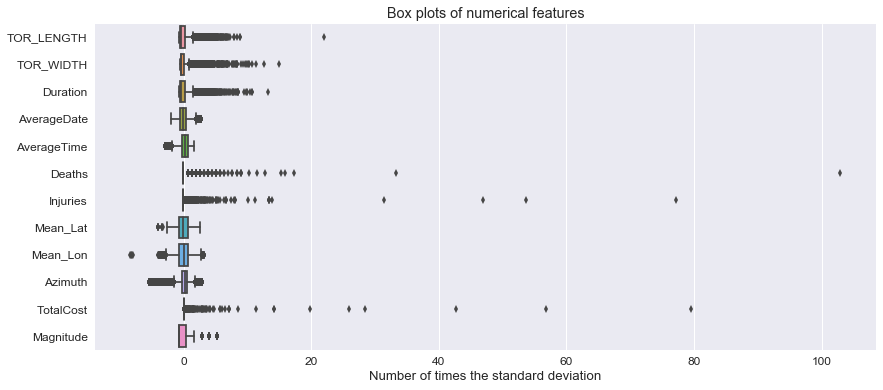

In [10]:
scaler = StandardScaler()
dfnum = df.drop(['TOR_F_SCALE','State','Source'],axis=1)
dfnum['Magnitude'] = df['TOR_F_SCALE'].map(convertEFtonb)
dfstd = pd.DataFrame(scaler.fit_transform(dfnum), columns=dfnum.columns)

plt.figure(figsize=(14,6))
sns.set(font_scale=1.2)
sns.boxplot(data=dfstd, orient='h')
plt.title("Box plots of numerical features")
plt.xlabel("Number of times the standard deviation")
plt.show()

- As seen in part 3, the outlier for TOR_LENGTH = 100 miles has to be removed, it was most likely entered wrongly in the original database
- The negative outliers for Mean_Lon correspond to Hawaii
- The other outliers actually correspond to stronger tornadoes and should not be removed

## Removing outlier and keeping only standardized numerical features:

We saw in [part 3](tornadoes_part3_eda_modelling_nlp_tsa.ipynb) that the dummy features created from "State" and "Source" did not improve our model accuracy. We are then just going to use the numerical features. As a consequence, our modelling will run faster.

In [11]:
# Removing tornado with outlier TOR_LENGTH > 20*std:
tornado_2007_2017 = dfstd[dfstd.TOR_LENGTH<20]

In [16]:
print raw_2007_2017.shape, df.shape, tornado_2007_2017.shape

(14538, 62) (14538, 14) (14537, 12)


In [17]:
tornado_2007_2017.head(2)

,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,TotalCost,Magnitude
0,-0.649575,-0.553936,-0.663909,0.71888,0.064657,-0.048934,-0.06017,0.992225,-0.148975,1.408556,-0.0423,-0.775497
1,-0.665453,-0.553936,-0.663909,0.71888,0.142239,-0.048934,-0.06017,0.978331,-0.115564,1.354156,-0.0423,-0.775497


# Modelling using numerical features

## Target / Feature matrix

In [12]:
X1 = tornado_2007_2017.drop(['Magnitude'], axis=1)
y1 = raw_2007_2017[raw_2007_2017.TOR_LENGTH<50]['TOR_F_SCALE']

## Train/test split

In [15]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X1, y1, test_size=0.3, stratify=y1,
                                                    random_state=31)

## Baseline

In [14]:
accuracy_baseline = ytest1.value_counts().get_values()[0]/float(ytest1.count())
print "Accuracy | Test\t\t | Baseline\t\t | EF0 tornados:\t", round(accuracy_baseline, 3)

Accuracy | Test		 | Baseline		 | EF0 tornados:	0.527


## Random Forest

Extensive modelling tests were performed in [part 3](Capstone_Yves_Tornadoes_Part3.ipynb) of the capstone. The next model is our best one obtained in part 3. This is our new reference.

In [16]:
# Taking the best RF hyperparameters from part 3:
rf6 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, 
                             min_samples_leaf=1, min_samples_split=9,
                             n_estimators=72, random_state=31)
rf6.fit(Xtrain1, ytrain1)

yhat1_rf6 = rf6.predict(Xtest1)
accuracy_rf6 = accuracy_score(ytest1, yhat1_rf6)
print "Accuracy | Test\t\t | Random Forest\t | Optimized params:\t", round(accuracy_rf6, 3)

Accuracy | Test		 | Random Forest	 | Optimized params:	0.732


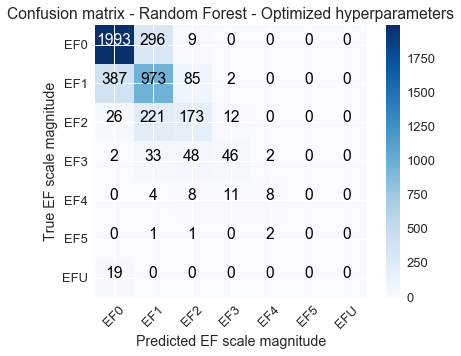

In [18]:
# Computing the confusion matrix
confmatrix_rf6 = confusion_matrix(ytest1, yhat1_rf6)

# Plotting it using the function:
plot_confusion_matrix(confmatrix_rf6, rf6.classes_,
                      'Confusion matrix - Random Forest - Optimized hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

In [20]:
clasreport_rf6 = classification_report(ytest1, yhat1_rf6)
print "Classification report from our optimized random forest:\n", clasreport_rf6

Classification report from our optimized random forest:
             precision    recall  f1-score   support

        EF0       0.82      0.87      0.84      2298
        EF1       0.64      0.67      0.65      1447
        EF2       0.53      0.40      0.46       432
        EF3       0.65      0.35      0.46       131
        EF4       0.67      0.26      0.37        31
        EF5       0.00      0.00      0.00         4
        EFU       0.00      0.00      0.00        19

avg / total       0.72      0.73      0.72      4362



/Users/Yves/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As we had noticed in part 3 with our analysis of the confusion matrix, the weaker tornadoes are well predicted, but the stronger ones less. This is clearly visible in the classification report. 
<br>EF0 precision and recall scores are great. However EF2 to EF5 tornadoes tend to be predicted as weaker. 
<br>The is due to the strong imbalance between classes (strong tornadoes are rare)
<br>The precision and recall scores can benefit from upsampling the rarer events. This is the next step we are going to perform. 

## Upsampling and redoing the modelling

The upsampling will be performed on the trained dataset to try and improve the precision and recall of the different categories, except the EF0 ones.
<br>The model scoring and validation will still be done on the test dataset.

In [23]:
# Checking the original dimensions of the train features:
Xtrain1.shape

(10175, 11)

**Example "stolen" from Raja (thank you!):**<br>
table_train_r=table_train[table_train['Relegated']==1]<br>
table_train_s=table_train[table_train['Relegated']==0]

table_train_r_upsample = resample(table_train_r, replace=True, n_samples=table_train_s.shape[0])<br>
table_train=pd.concat([table_train_r_upsample,table_train_s],axis=0)

In [21]:
# Re-incorporating the magnitude:
Xtrain2 = pd.concat([Xtrain1, pd.DataFrame(ytrain1)], axis=1)
print Xtrain2.shape
Xtrain2.head(2)

(10175, 12)


,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,TotalCost,TOR_F_SCALE
13291,-0.658648,-0.452255,-0.521007,0.421973,0.038473,-0.048934,-0.06017,0.243112,1.263833,0.354663,-0.041447,EF0
1056,2.473960,0.869589,1.908334,1.080332,0.219821,-0.048934,-0.06017,1.206906,1.025230,0.418744,0.156800,EF2


In [22]:
# Creating a dictionary of dataframes, one for each magnitude:
Xtrain2_perMag = {}
for mag in ['EFU', 'EF0', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']:
    Xtrain2_perMag[mag] = Xtrain2[Xtrain2['TOR_F_SCALE']==mag]

In [23]:
# Upsampling each dataframe based on the number of rows of the majority class EF0:
Xtrain2_upsampled = {}

for mag in ['EF0', 'EFU', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']:
    
    if mag == 'EF0':
        Xtrain2_upsampled['EF0'] = Xtrain2_perMag['EF0']
    else:
        # Bootstrapping method is used:
        Xtrain2_upsampled[mag] = resample(Xtrain2_perMag[mag], replace=True,
                                          n_samples=Xtrain2_perMag['EF0'].shape[0],
                                          random_state=31)
    # QCs:
    print "{} Original shape :\t".format(mag), Xtrain2_perMag[mag].shape,\
          "\tUpsample shape {}:".format(mag), Xtrain2_upsampled[mag].shape
        

EF0 Original shape :	(5362, 12) 	Upsample shape EF0: (5362, 12)
EFU Original shape :	(43, 12) 	Upsample shape EFU: (5362, 12)
EF1 Original shape :	(3375, 12) 	Upsample shape EF1: (5362, 12)
EF2 Original shape :	(1009, 12) 	Upsample shape EF2: (5362, 12)
EF3 Original shape :	(304, 12) 	Upsample shape EF3: (5362, 12)
EF4 Original shape :	(72, 12) 	Upsample shape EF4: (5362, 12)
EF5 Original shape :	(10, 12) 	Upsample shape EF5: (5362, 12)


In [24]:
# Concatenating all the upsampled dataframes
Xtrain2_df = pd.concat([Xtrain2_upsampled['EF0'], Xtrain2_upsampled['EF1'], Xtrain2_upsampled['EF2'], 
                        Xtrain2_upsampled['EF3'], Xtrain2_upsampled['EF4'], Xtrain2_upsampled['EF5'],
                        Xtrain2_upsampled['EFU']], ignore_index=True, axis=0)
print Xtrain2_df.shape

(37534, 12)


In [25]:
# Recreating the feature matrix and target for modelling:
ytrain2 = Xtrain2_df.TOR_F_SCALE
Xtrain2_df.drop(['TOR_F_SCALE'], axis=1, inplace=True)
print Xtrain2_df.shape, ytrain2.shape

(37534, 11) (37534,)


In [26]:
# Taking the best RF hyperparameters from part 3:
rf7 = RandomForestClassifier(criterion='entropy', max_depth=18, max_features=0.4, min_samples_leaf=1,
                             min_samples_split=9, n_estimators=72, random_state=31)
rf7.fit(Xtrain2_df, ytrain2)

yhat1_rf7 = rf7.predict(Xtest1)
accuracy_rf7 = accuracy_score(ytest1, yhat1_rf7)
print "Accuracy | Test\t\t | Random Forest\t | Original sampling\t | Part 3 params:\t", round(accuracy_rf7, 3)

Accuracy | Test		 | Random Forest	 | Original sampling	 | Part 3 params:	0.723


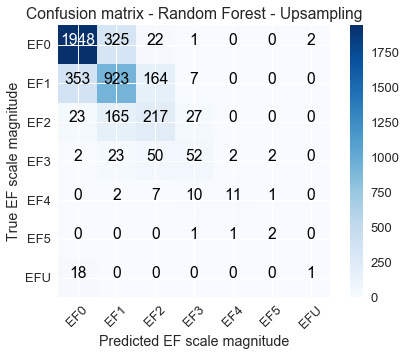

In [27]:
# Computing the confusion matrix
confmatrix_rf7 = confusion_matrix(ytest1, rf7.predict(Xtest1))

# Plotting it using the function:
plot_confusion_matrix(confmatrix_rf7, rf7.classes_,
                      'Confusion matrix - Random Forest - Upsampling',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

In [28]:
clasreport_rf7 = classification_report(ytest1, yhat1_rf7)
print "Classification report after upsampling:\n", clasreport_rf7

Classification report after upsampling:
             precision    recall  f1-score   support

        EF0       0.83      0.85      0.84      2298
        EF1       0.64      0.64      0.64      1447
        EF2       0.47      0.50      0.49       432
        EF3       0.53      0.40      0.45       131
        EF4       0.79      0.35      0.49        31
        EF5       0.40      0.50      0.44         4
        EFU       0.33      0.05      0.09        19

avg / total       0.72      0.72      0.72      4362



Comments on the confusion matrix and classification report:
- This is a successful test. The true positives of EF1 to EF5 tornadoes has increased. The upsampling helps predicting, for each magnitude over EF0, the majority of tornadoes in their true magnitude. It was not the case before.
- Precision and recall of EF5 tornadoes has considerably improved (none were preductied correctly before upsampling).
- Nevertheless, EF0 tornadoes are not predicted as well. This is why overall the accuracy has decreased from 0.732 to 0.723.
- Using still the upsampled data, we are now going to fine tune the Random Forest hyper parameters.

In [105]:
# Flag to specify if GridSearch has to be redone or not:
# Just not to rerun accidently the following whole gridsearch (which takes ages) accidently
redo_RFgridsearch1 = False

In [37]:
if redo_RFgridsearch1:
    rf1 = RandomForestClassifier(random_state=31)
    params_randfor_v1 = {'criterion': ['entropy'],
                         'max_depth': [16,18,20,22,24,26],
                         'max_features': [0.3,0.4,0.5,0.6],
                         'n_estimators': [80],
                         'min_samples_split': [8,9,10,11],
                         'min_samples_leaf': [1]
                        }

    rf8 = GridSearchCV(rf1, param_grid=params_randfor_v1, cv=5, verbose=1, n_jobs=2)

    rf8.fit(Xtrain2_df, ytrain2)
    print "The optimized parameters are:\n", rf8.best_params_
    print "\nAccuracy | Train CV5\t | Random Forest\t | Upsampling\t | Optimal params:\t", round(rf8.best_score_, 3)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 16.7min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 41.2min
[Parallel(n_jobs=2)]: Done 480 out of 480 | elapsed: 45.2min finished


The optimized parameters are:
{'min_samples_leaf': 1, 'n_estimators': 80, 'min_samples_split': 8, 'criterion': 'entropy', 'max_features': 0.4, 'max_depth': 24}

Accuracy | Train CV5	 | Random Forest	 | Upsampling	 | Optimal params:	0.958


In [31]:
if redo_RFgridsearch1:
    yhat2_rf8 = rf8.best_estimator_.predict(Xtest1)
else:
    rf8 = RandomForestClassifier(random_state=31, min_samples_leaf=1, n_estimators=80, 
                                 min_samples_split=8,
                                 criterion='entropy', max_features=0.4, max_depth=24)
    rf8.fit(Xtrain2_df, ytrain2)
    yhat2_rf8 = rf8.predict(Xtest1)
accuracy_rf8 = accuracy_score(ytest1, yhat2_rf8)
print "Accuracy | Test\t\t | Random Forest\t | Upsampling\t | Optimized params:\t", round(accuracy_rf8, 3)

Accuracy | Test		 | Random Forest	 | Upsampling	 | Optimized params:	0.722


#### Comments about GridSearch on upsampled data:
- This is a clear example of overfitting: the train set gives an excellent score of 96% whereas the test gives 72%.
- It was kind of expected with an upsampled train dataset. It is not recommended to gridsearch upsampled data!

## Conclusions and summary statistics

### Accuracy, precision and recall:

+ **Accuracy**: overall correct prediction of a tornado, whatever its scale. <br>As there is a big imabalance, this statistic mostly shows how well the EF0 and EF1 tornadoes are correctly predicted.
<br><br>
+ True Postive of an EFx tornado (with x varying from 0 to 5): number of correctly predicted EFx tornadoes.
+ False Negatives of an EFx tornado: total number of EFx tornadoes wrongly predicted as another type.
+ False Postives of an EFx tornado: total number of tornadoes wrongly predicted as an EFx tornado.
<br><br>
+ **Recall of an EFx tornado**: $$ Recall = \frac{TP}{TP + FN}\ $$ It is a useful statistic to measure how well a certain type of tornado is predicted.
    - The lower the recall of EFx, the higher the number of EFx tornadoes are wrongly predicted.
    - The higher the recall of EFx, the better the EFx tornado is predicted.
<br><br>
+ **Precision of an EFx tornado**: $$ Precision = \frac{TP}{TP + FP}\ $$ It measures how well other types of tornadoes are not predicted as EFx.
    - The lower the precision of EFx, the higher the number of other types of tornadoes are predicted as EFx.
    - The higher the precision of EFx, the lower other types of tornadoes are wrongly predicted as EFx.
<br><br>
+ **To summarize:**
    - **The accuracy gives us a measure of how well the model performs globally.**
    - **The recall gives us a detailed measure of how well each type of tornado is correctly predicted. Because of the big imbalance between weaker and stronger tornadoes, this is the most important measure in this project.**

Let's compare the statistics with / without upsampling. 
<br>*Note: the different statistics were computed on the test set*

| Accuracy | Model description | Score |
| :---: | :--- | :--- |
|  | Baseline | 0.527 |
|  | Random Forest - no upsampling | 0.732 |
|  | Random Forest - with upsampling | 0.723 |

| Random Forest Recall | No upsampling | With upsampling |
| :---: | :---: | :---: |
| EF0 | 0.87 | 0.85 |
| EF1 | 0.67 | 0.64 |
| EF2 | 0.40 | 0.50 |
| EF3 | 0.35 | 0.40 |
| EF4 | 0.26 | 0.35 |
| EF5 | 0.00 | 0.50 |

*For comparisons with other types of models including logistic regression, please check [part 3](Capstone_Yves_Tornadoes_Part3.ipynb)*

**The Random Forest model generated by upsampling the training set is the best option to an efficient prediction of all types of tornadoes.**

### ROC curves

- The Receiver Operating Characteristic curve is another graph used in statistics to compare models. It is defined for binomial targets. 
- If used in a multinomial case, it compares each class with the total of remaining classes as one separate class.
- It represents the True Postive Rate (or recall) as a function of the False Positive Rate (FPR). Logically, a good model will therefore produce a point close to (0;1) as a recall of 1 and a FPR of 0 correspond to perfection.

#### Probabilities

We first have to derive the associated probabilities for each tornado

In [57]:
predicted_probs_rf6_7 = pd.concat([pd.DataFrame(ytest1).reset_index(drop=True),
                                   pd.DataFrame(yhat1_rf6, columns=['pred_rf6']),
                                   pd.DataFrame(yhat1_rf7, columns=['pred_rf7']),
                                   pd.DataFrame(rf6.predict_proba(Xtest1), 
                                                columns=["rf6_{}".format(str(i)) 
                                                         for i in list(rf6.classes_)]),
                                   pd.DataFrame(rf7.predict_proba(Xtest1), 
                                                columns=["rf7_{}".format(str(i)) 
                                                         for i in list(rf7.classes_)])],
                                axis=1)
predicted_probs_rf6_7.head(10)

,TOR_F_SCALE,pred_rf6,pred_rf7,rf6_EF0,rf6_EF1,rf6_EF2,rf6_EF3,rf6_EF4,rf6_EF5,rf6_EFU,rf7_EF0,rf7_EF1,rf7_EF2,rf7_EF3,rf7_EF4,rf7_EF5,rf7_EFU
0,EF1,EF0,EF0,0.534267,0.337432,0.117267,0.001389,0.000000,0.0,0.009645,0.382310,0.346674,0.271016,0.000000,0.0,0.0,0.000000
1,EF1,EF1,EF1,0.300914,0.620458,0.076578,0.002050,0.000000,0.0,0.000000,0.282633,0.597741,0.119626,0.000000,0.0,0.0,0.000000
2,EF0,EF0,EF0,0.739870,0.260130,0.000000,0.000000,0.000000,0.0,0.000000,0.825108,0.174892,0.000000,0.000000,0.0,0.0,0.000000
3,EF0,EF1,EF1,0.205096,0.582587,0.169694,0.035431,0.007192,0.0,0.000000,0.212897,0.483391,0.275934,0.027778,0.0,0.0,0.000000
4,EF0,EF2,EF2,0.106334,0.440584,0.449378,0.003704,0.000000,0.0,0.000000,0.065985,0.379462,0.540664,0.013889,0.0,0.0,0.000000
5,EF0,EF0,EF0,0.807659,0.138022,0.018519,0.000000,0.000000,0.0,0.035801,0.803041,0.171959,0.025000,0.000000,0.0,0.0,0.000000
6,EF1,EF1,EF1,0.368901,0.600438,0.030661,0.000000,0.000000,0.0,0.000000,0.383022,0.538993,0.077985,0.000000,0.0,0.0,0.000000
7,EF0,EF0,EF0,0.582347,0.402375,0.015278,0.000000,0.000000,0.0,0.000000,0.520041,0.460327,0.005743,0.013889,0.0,0.0,0.000000
8,EF1,EF0,EF0,0.800220,0.198539,0.001157,0.000000,0.000000,0.0,0.000084,0.654793,0.310458,0.034749,0.000000,0.0,0.0,0.000000
9,EF0,EF1,EF1,0.310378,0.448605,0.141745,0.079635,0.013580,0.0,0.006057,0.276614,0.380976,0.281646,0.046875,0.0,0.0,0.013889


#### Plot

I am going to do the plotting of the ROC curves for each tornado scale, and comparing the model without and with upsampling.

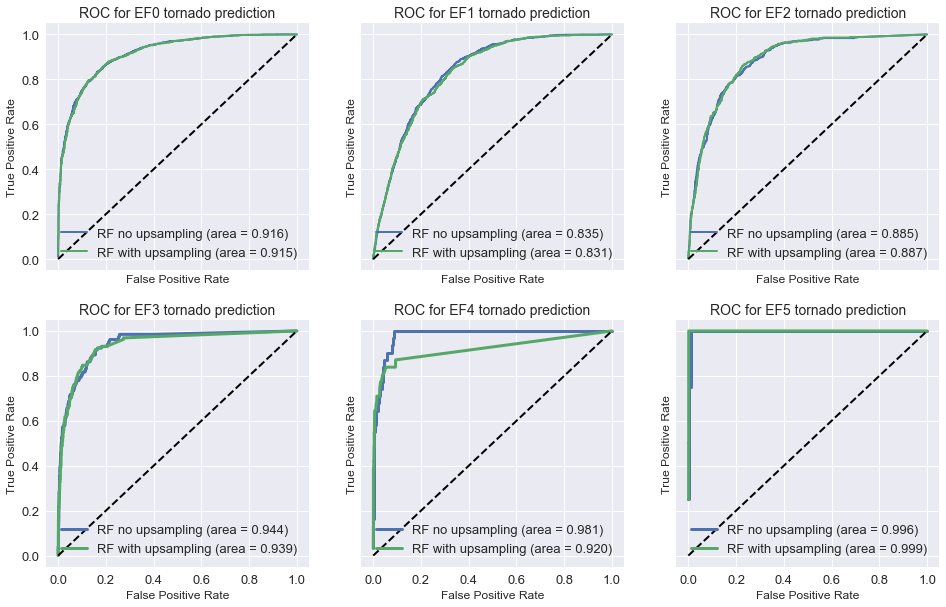

In [89]:
# Initializing the roc/auc attributes:
fpr_rf6 = {}
tpr_rf6 = {}
fpr_rf7 = {}
tpr_rf7 = {}
roc_auc_rf6 = {}
roc_auc_rf7 = {}

# Computing the FPR, TPR and area under the ROC curve for each tornado and each model:
for i in range(6):
    fpr_rf6[i], tpr_rf6[i], _ = roc_curve(predicted_probs_rf6_7.TOR_F_SCALE.map(convertEFtonb),
                                          proba_rf6[i],
                                          pos_label=i)
    roc_auc_rf6[i] = auc(fpr_rf6[i], tpr_rf6[i])

    fpr_rf7[i], tpr_rf7[i], _ = roc_curve(predicted_probs_rf6_7.TOR_F_SCALE.map(convertEFtonb),
                                          proba_rf7[i],
                                          pos_label=i)
    roc_auc_rf7[i] = auc(fpr_rf7[i], tpr_rf7[i])

# Dictionnaries of the probabilities for each tornado:
proba_rf6 = {0: predicted_probs_rf6_7.rf6_EF0, 1: predicted_probs_rf6_7.rf6_EF1,
             2: predicted_probs_rf6_7.rf6_EF2, 3: predicted_probs_rf6_7.rf6_EF3, 
             4: predicted_probs_rf6_7.rf6_EF4, 5: predicted_probs_rf6_7.rf6_EF5}
proba_rf7 = {0: predicted_probs_rf6_7.rf7_EF0, 1: predicted_probs_rf6_7.rf7_EF1,
             2: predicted_probs_rf6_7.rf7_EF2, 3: predicted_probs_rf6_7.rf7_EF3,
             4: predicted_probs_rf6_7.rf7_EF4, 5: predicted_probs_rf6_7.rf7_EF5}

# Setting the plots:
fig, ax = plt.subplots(2,3, figsize=(16,10), sharex=True, sharey=True)

# Plotting first the EF0 to EF2 tornadoes:
for i in range(3):
    ax[0][i].plot(fpr_rf6[i], tpr_rf6[i],
                  label='RF no upsampling (area = %0.3f)' %roc_auc_rf6[i], linewidth=2)
    ax[0][i].plot(fpr_rf7[i], tpr_rf7[i],
                  label='RF with upsampling (area = %0.3f)' %roc_auc_rf7[i], linewidth=2) 
    ax[0][i].plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax[0][i].set_xlim([-0.05, 1.05])
    ax[0][i].set_ylim([-0.05, 1.05])
    ax[0][i].set_xlabel('False Positive Rate', fontsize=12)
    ax[0][i].set_ylabel('True Positive Rate', fontsize=12)
    ax[0][i].set_title('ROC for EF{} tornado prediction'.format(i), fontsize=14)
    ax[0][i].legend(loc="lower right")

# Plotting the EF3 to EF5 tornadoes:
for i in range(3,6):
    ax[1][i-3].plot(fpr_rf6[i], tpr_rf6[i],
                  label='RF no upsampling (area = %0.3f)' %roc_auc_rf6[i], linewidth=3)
    ax[1][i-3].plot(fpr_rf7[i], tpr_rf7[i],
                  label='RF with upsampling (area = %0.3f)' %roc_auc_rf7[i], linewidth=3)
    ax[1][i-3].plot([0, 1], [0, 1], 'k--', linewidth=2)
    ax[1][i-3].set_xlim([-0.05, 1.05])
    ax[1][i-3].set_ylim([-0.05, 1.05])
    ax[1][i-3].set_xlabel('False Positive Rate', fontsize=12)
    ax[1][i-3].set_ylabel('True Positive Rate', fontsize=12)
    ax[1][i-3].set_title('ROC for EF{} tornado prediction'.format(i), fontsize=14)
    ax[1][i-3].legend(loc="lower right")

Comments:
- The results are completely unexpected: EF5 tornadoes perform the best, and for EF4 tornadoes, without upsampling is better. The results do not correspond to our previous analyses of the confusion matrix and classification report.
- Either displaying the ROC curves for each tornado against the rest of tornadoes is not a reliable way of interpreting the validity of the models, or I need to think more to understand these results, or I made some mistake in my previous computations of the probabilities!
- Further investigation will be necessary.

### Random Forest most important features:

Let's display the features with the most influence to the prediction of the magnitude.
<br>We will do it for the two models without and with upsampling:

In [93]:
def plot_RF_important_features(XtrainDF=Xtrain1, fitted_rf=rf6, weight_threshold_for_display=0,
                               figsize=(6,4),
                               title_test="Most important features taken from our best RF model so far\n"):
    
    """Plots for the train dataset 'Xtrain1' the most important features of a fitted random forest
    model 'fitted_rf' over the weight 'weight_threshold_for_display'"""
    
    importanceDF = pd.DataFrame({'Importances': fitted_rf.feature_importances_},
                                index = XtrainDF.columns)
    most_imp = importanceDF.sort_values(by="Importances", ascending=False)
    # Horizontal bar plot
    plt.figure(figsize=figsize)
    sns.barplot(list(most_imp[most_imp['Importances']>weight_threshold_for_display].values), 
                [str(i) for i in 
                 list(most_imp[most_imp['Importances']>weight_threshold_for_display].index)], 
                orient='h')
    plt.xlabel("Weight")
    plt.ylabel("Predictors")
    plt.xlim([0, 0.25])
    plt.title(title_test)
    plt.show()

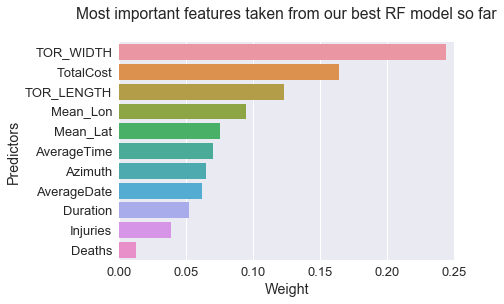

In [94]:
plot_RF_important_features()

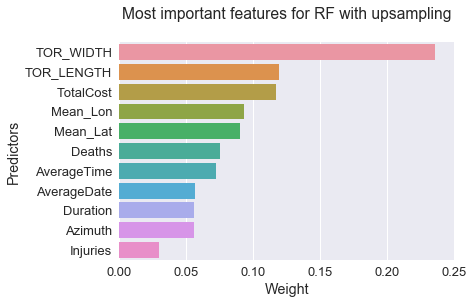

In [95]:
plot_RF_important_features(fitted_rf=rf7, title_test="Most important features for RF with upsampling\n")

Comments on the most important features:
- It is equally very interesting to discover which features are the most influential on the prediction of the tornado's magnitude, and to compare the lists between with and without upsampling.
- The tornado's path maximum width is by far the parameter which predicts the best the tornado strength
- Without upsampling, the emphasis of the model is put on the weaker tornadoes. Deaths and injuries are not a big factor to predict them, as even for larger tornadoes, the casualties are usually and fortunately not very high.<br>However numerous casualties for a particular tornado indicates that it is a strong one, which is why with upsampling, the number of deaths goes up in the list.
- As we had seen before in part 2 and 3, the location of the tornado (latitude and longitude) is a big influencer.

# Modelling using narratives - NLP

- Each tornado includes a narrative, which we can use as a predictor for the magnitude.
- In [part 3](tornadoes_part3_eda_modelling_nlp_tsa.ipynb), I managed to get a good accuracy score of 0.787 with a simple CountVectorizer and Multinomial Naive Bayes model. For a reminder the baseline is 0.527 and the best accuracy obtained using RF with numerical features is 0.732.
- Lemmatization and Tf-IDF did not help improving the accuracy. 
- Pending things were: 
    - enhancing the stop word list, especially with any reference to the magnitude in the text
    - testing of removing any numbers
    - creating new word nodamage when there is actually no damage
    - Testing more ngrams

## Best CountVectorizer and Multinomial Naive Bayes model obtained in part 3:

In [13]:
# Feature matrix (removing the bad row already removed before for tornado_2007_2017)
X3 = raw_2007_2017[raw_2007_2017.TOR_LENGTH<50]['EVENT_NARRATIVE']

# Train/test split
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(X3, y1, stratify=y1, test_size=0.3, random_state=31)
print Xtrain3.shape, Xtest3.shape, ytrain3.shape, ytest3.shape

(10175,) (4362,) (10175,) (4362,)


In [19]:
# Function that accepts a vectorizer and calculates the accuracy 
def tokenize_naiveb_scores(vect, Xtrain=Xtrain3, Xtest=Xtest3,
                  ytrain=ytrain3, ytest=ytest3, 
                  print_scores=False, print_extra_info='Part3 count vectorizer'):
    
    '''From a CountVectorizer model input and a train and test feature matrix and target
    Fits a Naive Bayes multinomial model on train data
    Outputs and optionally prints the test accuracy score and recall score for each magnitude'''
    
    Xtrain_vect = vect.fit_transform(Xtrain)
    Xtest_vect = vect.transform(Xtest)
    
    nb = MultinomialNB()
    nb.fit(Xtrain_vect, ytrain)
    yhat = nb.predict(Xtest_vect)
    
    accuracy = round(accuracy_score(ytest, yhat), 3)
 
    recall=[]
    for i in range(6):
        recall.append(round(recall_score(ytest, yhat, labels=['EF{}'.format(i)], average='macro'),
                            3))
        
    if print_scores:
        print "Multinomial NB\t | {} features | {}\t\t\t | Accuracy:\t".format(Xtrain_vect.shape[1],
                                                                               print_extra_info),\
              accuracy
        for i in range(6):
            print "\t\t\t\t\t\t\t\t\t\t | Recall EF{}:\t".format(i), recall[i]

    return [accuracy]+recall

In [20]:
# Best countvec and modelling from part 3:
countvec2 = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000)
tokenize_naiveb_scores(countvec2, print_scores=True)

Multinomial NB	 | 20000 features | Part3 count vectorizer			 | Accuracy:	0.795
										 | Recall EF0:	0.85
										 | Recall EF1:	0.811
										 | Recall EF2:	0.65
										 | Recall EF3:	0.427
										 | Recall EF4:	0.032
										 | Recall EF5:	0.25


[0.795, 0.85, 0.811, 0.65, 0.427, 0.032, 0.25]

In [265]:
# Displaying the most frequent words:
Xtrain3_vec2 = countvec2.fit_transform(Xtrain3)
pd.DataFrame(Xtrain3_vec2.todense(),
             columns=countvec2.get_feature_names()).sum(axis=0).sort_values(ascending=False).head(3)

tornado    23072
damage     14396
county      8999
dtype: int64

#### Creating scores dictionnaries

For later overall graphic analysis, I am going to create dictionnaries containing the accuracy and recall scores for each test:

In [276]:
accuracy_nlp = {}
recallEF0_nlp = {}
recallEF1_nlp = {}
recallEF2_nlp = {}
recallEF3_nlp = {}
recallEF4_nlp = {}
recallEF5_nlp = {}
scores_nlp = [accuracy_nlp, recallEF0_nlp, recallEF1_nlp, recallEF2_nlp, recallEF3_nlp,
              recallEF4_nlp, recallEF5_nlp]

In [277]:
tmp_score_list = tokenize_naiveb_scores(countvec2)
for i, score in enumerate(scores_nlp):
    score['cntv2 - part3 reference'] = tmp_score_list[i]

recallEF2_nlp

{'cntv2 - part3 reference': 0.65}

## New tests

### Testing nltk stopwords:

In [122]:
from nltk.corpus import stopwords
stopnltk = [str(t) for t in stopwords.words('english')]
len(stopnltk)

153

In [270]:
# Countvec using nltk stopwords and modelling from part 3:
countvec3 = CountVectorizer(stop_words=stopnltk, ngram_range=(1,2), max_features=20000)
tokenize_naiveb_scores(countvec3, print_scores=True, print_extra_info='nltk stopwords')

Multinomial NB	 | 20000 features | nltk stopwords			 | Accuracy:	0.792
										 | Recall EF0:	0.848
										 | Recall EF1:	0.802
										 | Recall EF2:	0.657
										 | Recall EF3:	0.412
										 | Recall EF4:	0.032
										 | Recall EF5:	0.25


[0.792, 0.848, 0.802, 0.657, 0.412, 0.032, 0.25]

- The accuracy score is not as good when using nltk stopwords
- Let's go back to the count vectorizer ones and work from there

In [278]:
# Saving the scores:
tmp_score_list = tokenize_naiveb_scores(countvec3)
for i, score in enumerate(scores_nlp):
    score['cntv3 - nltk stopwords'] = tmp_score_list[i]
recallEF2_nlp

{'cntv2 - part3 reference': 0.65, 'cntv3 - nltk stopwords': 0.657}

### Handling "no damage" references

In [21]:
countvec_stopwords1 = list(countvec2.get_stop_words())
len(countvec_stopwords1)

318

The number of stopwords in countvectorizer is more important than nltk. That may be the reason why it gives better result.

Removing 'no' from the list as it can usefully be associated with 'damage' for instance:

In [126]:
countvec_stopwords2 = countvec_stopwords1
for word in ['no']:
    countvec_stopwords2.remove(word)
len(countvec_stopwords2)

317

Redoing the modelling:

In [156]:
countvec4 = CountVectorizer(stop_words=countvec_stopwords2, ngram_range=(1,2),
                            max_features=20000)
tokenize_naiveb_scores(countvec4, print_scores=True,
                       print_extra_info='countvec stopwords including "no"')

Multinomial NB	 | 20000 features | countvec stopwords including "no"			 | Accuracy:	0.796
										 | Recall EF0:		0.844
										 | Recall EF1:		0.82
										 | Recall EF2:		0.667
										 | Recall EF3:		0.397
										 | Recall EF4:		0.0
										 | Recall EF5:		0.25


A bit better. We can now check the most important words and/or combination of words:

In [128]:
Xtrain3_vec4 = countvec4.fit_transform(Xtrain3)
pd.DataFrame(Xtrain3_vec4.todense(),
             columns=countvec4.get_feature_names()).sum(axis=0).sort_values(ascending=False).head(10)

tornado      23072
damage       14396
county        8999
trees         8257
road          6959
near          4731
path          4437
miles         4230
touched       4033
northeast     3951
dtype: int64

No combination of words can be seen in the top 10 list. Let's check now that "no damage" is indeed included in the list:

In [25]:
"no damage" in countvec4.get_feature_names()

True

In [26]:
"no" in countvec4.get_feature_names()

True

The slight improve may be explained by the fact that "no damage" is now a feature. However "no" is also becoming a feature on its own. One way to fix this is to replace in the original text "no damage" by a new word "no_damage" and leave "no" as a stopword:

In [16]:
def replace_nodamage(txt):
    '''Replaces 'no damage' by 'nodamage' in a text'''
    txt = txt.replace('no damage','nodamage')
    txt = txt.replace('no reported damage','noreporteddamage')
    txt = txt.replace('any damage','nodamage')
    txt = txt.replace('not damage','nodamage')
    return txt

In [17]:
# Applying and checking the function:
Xtrain3_nodamage = Xtrain3.map(replace_nodamage)
Xtest3_nodamage = Xtest3.map(replace_nodamage)
print Xtrain3[3]
print Xtrain3_nodamage[3]

This was a rope shaped tornado that was over range land and did not damage anything.
This was a rope shaped tornado that was over range land and did nodamage anything.


In [157]:
countvec5 = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=20000)
tokenize_naiveb_scores(countvec5, Xtrain3_nodamage, Xtest3_nodamage, print_scores=True,
                       print_extra_info="nodamage new word")

Multinomial NB	 | 20000 features | nodamage new word			 | Accuracy:	0.796
										 | Recall EF0:		0.848
										 | Recall EF1:		0.817
										 | Recall EF2:		0.657
										 | Recall EF3:		0.405
										 | Recall EF4:		0.0
										 | Recall EF5:		0.25


We get the same accuracy, but the words are better prepared. So we will take this result as our new reference.
<br>Note: recall for EF4 tornadoes is still bad.

In [279]:
# Saving the scores:
tmp_score_list = tokenize_naiveb_scores(countvec5, Xtrain3_nodamage, Xtest3_nodamage)
for i, score in enumerate(scores_nlp):
    score['cntv5 - nodamage new word'] = tmp_score_list[i]
recallEF2_nlp

{'cntv2 - part3 reference': 0.65,
 'cntv3 - nltk stopwords': 0.657,
 'cntv5 - nodamage new word': 0.657}

### Removing references to target:

Any reference to the supposed EF scale (our target) in the narrative would not provide a fair judgement of a model's quality. We should add ef0, ef1, ..., ef5 to the stopwords for a fairer modelling:

In [22]:
countvec_stopwords3 = countvec_stopwords1 + ["ef{}".format(i) for i in range(6)] \
                                          + ["f{}".format(i) for i in range(6)] \
                                          + ['efu', 'fu']
countvec_stopwords3[-10:]

['ef4', 'ef5', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'efu', 'fu']

In [293]:
countvec6 = CountVectorizer(stop_words=countvec_stopwords3, ngram_range=(1,2), max_features=20000)
tokenize_naiveb_scores(countvec6, Xtrain3_nodamage, Xtest3_nodamage, 
                       print_scores=True, print_extra_info='target references removed')

Multinomial NB	 | 20000 features | target references removed			 | Accuracy:	0.771
										 | Recall EF0:	0.829
										 | Recall EF1:	0.79
										 | Recall EF2:	0.618
										 | Recall EF3:	0.321
										 | Recall EF4:	0.032
										 | Recall EF5:	0.25


[0.771, 0.829, 0.79, 0.618, 0.321, 0.032, 0.25]

As expected, with no reference to the target, the accuracy score is worse. But much fairer. And better than our previous models using the numerical features (0.732)

In [281]:
# Saving the scores:
tmp_score_list = tokenize_naiveb_scores(countvec6, Xtrain3_nodamage, Xtest3_nodamage)
for i, score in enumerate(scores_nlp):
    score['cntv6 - no reference to target'] = tmp_score_list[i]
recallEF2_nlp

{'cntv2 - part3 reference': 0.65,
 'cntv3 - nltk stopwords': 0.657,
 'cntv5 - nodamage new word': 0.657,
 'cntv6 - no reference to target': 0.618}

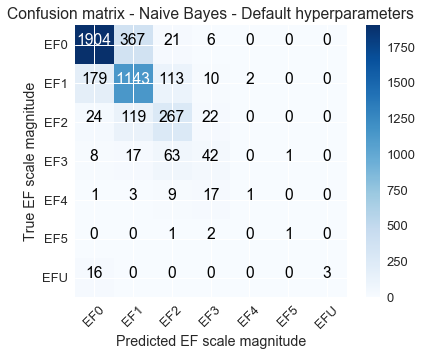

In [315]:
nb = MultinomialNB()
nb.fit(Xtrain3_vec6, ytrain3)
yhat3_vec6 = nb.predict(Xtest3_vec6)

# Computing the confusion matrix
confmatrix_nb = confusion_matrix(ytest3, yhat3_vec6)

# Plotting it using the function:
plot_confusion_matrix(confmatrix_nb, nb.classes_,
                      'Confusion matrix - Naive Bayes - Default hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

- EF0 to EF2 tornadoes: their predictions are in majority correct.
- EF3 to EF5 tornadoes: they are predicted in majority as weaker.
- In all cases it is better than RF from numerical features
- To improve on this, we could try upsampling on just the EF3 to EF5 tornadoes

But first let's test removing any reference to numbers and digits, which could give info on wind speed, and I would preferably like to base our modelling only on narrative text.

### Removing references to numbers:

In [159]:
def remove_nbs_from_text(txt):
    '''Removes any digit from a text'''
    for digitchar in [str(digit) for digit in range(10)]:
        txt = txt.replace(digitchar,'')
    txt = txt.replace('-',' ').replace('  ',' ').replace(' .','.').replace(' ,',',')
    return txt

In [160]:
Xtrain3_nonb = Xtrain3_nodamage.map(remove_nbs_from_text)
Xtest3_nonb = Xtest3_nodamage.map(remove_nbs_from_text)

In [112]:
# QCing the function:
print Xtrain3[10],"\n"
print Xtrain3_nonb[10]

A tornado touched down along Moorefield Road, just to the east of State Route 4.  Trees were either uprooted or snapped off towards their tops with additional large limbs down from other trees.  Some minor structural damage occured as well along the 250 yard damage path.  The tornado was rated EF-0 with top wind speeds of 70 mph. 

A tornado touched down along Moorefield Road, just to the east of State Route. Trees were either uprooted or snapped off towards their tops with additional large limbs down from other trees. Some minor structural damage occured as well along the yard damage path. The tornado was rated EF with top wind speeds of mph.


In [202]:
# As number have already been removed, we just need to add ef or f to the stopword list:
countvec_stopwords4 = countvec_stopwords1 + ["ef", "f", 'efu', 'fu']
countvec_stopwords4[-10:]

['so', 'five', 'the', 'first', 'whereas', 'once', 'ef', 'f', 'efu', 'fu']

In [203]:
countvec7 = CountVectorizer(stop_words=countvec_stopwords4, ngram_range=(1,2),
                            max_features=20000)
tokenize_naiveb_scores(countvec7, Xtrain3_nonb, Xtest3_nonb, print_scores=True,
                       print_extra_info='no number')

Multinomial NB	 | 20000 features | no number			 | Accuracy:	0.705
										 | Recall EF0:		0.768
										 | Recall EF1:		0.749
										 | Recall EF2:		0.444
										 | Recall EF3:		0.237
										 | Recall EF4:		0.0
										 | Recall EF5:		0.25


Well, we have lost even more accuracy

Actually, it is probably better to keep references to numbers and wind speed in particular, as they are an indication about the strength of a tornado, and not a direct reference to the target.

In [282]:
# Saving the scores:
tmp_score_list = tokenize_naiveb_scores(countvec7, Xtrain3_nonb, Xtest3_nonb)
for i, score in enumerate(scores_nlp):
    score['cntv7 - no reference to numbers'] = tmp_score_list[i]
recallEF2_nlp

{'cntv2 - part3 reference': 0.65,
 'cntv3 - nltk stopwords': 0.657,
 'cntv5 - nodamage new word': 0.657,
 'cntv6 - no reference to target': 0.618,
 'cntv7 - no reference to numbers': 0.444}

### Stochastic Gradient Descent:

Trying this other model widely used in NLP when having big datasets

In [335]:
# Function that accepts a vectorizer and calculates the accuracy via Stochastic Gradient Descent
# modelling
def tokenize_sgd_scores(vect, Xtrain=Xtrain3, Xtest=Xtest3, ytrain=ytrain3, ytest=ytest3,
                        print_scores=False, print_extra_info='Default stopwords'):
    
    '''From a CountVectorizer model input and a train and test feature matrix and target
    Fits a Stochastic Gradient Descent model on train data
    Outputs and optionally prints the test accuracy score and recall score for each magnitude'''
    
    Xtrain_vect = vect.fit_transform(Xtrain)
    Xtest_vect = vect.transform(Xtest)
    
    sgd = SGDClassifier(random_state=31)
    sgd.fit(Xtrain_vect, ytrain)
    yhat = sgd.predict(Xtest_vect)
    
    accuracy = round(accuracy_score(ytest, yhat), 3)
 
    recall=[]
    for i in range(6):
        recall.append(round(recall_score(ytest, yhat, labels=['EF{}'.format(i)],
                                         average='macro'), 3))
        
    if print_scores:
        print "Stochastic GD\t | {} features | {}\t | Accuracy:\t".format(Xtrain_vect.shape[1],
                                                                          print_extra_info),\
              accuracy
        for i in range(6):
            print "\t\t\t\t\t\t\t\t\t | Recall EF{}:\t".format(i), recall[i]

    return [accuracy]+recall

In [336]:
tokenize_sgd_scores(countvec6, Xtrain3_nodamage, Xtest3_nodamage, 
                    print_scores=True, print_extra_info='cntv6 - no reference to target')

Stochastic GD	 | 20000 features | cntv6 - no reference to target	 | Accuracy:	0.78
									 | Recall EF0:	0.888
									 | Recall EF1:	0.724
									 | Recall EF2:	0.528
									 | Recall EF3:	0.565
									 | Recall EF4:	0.226
									 | Recall EF5:	0.25


[0.78, 0.888, 0.724, 0.528, 0.565, 0.226, 0.25]

- The accuracy is better than Naive Bayes (0.771). 
- Recall for EF0, EF3 and EF4 tornadoes has improved. 
- Recall for EF1 and EF2 has worsened.
- Overall I would say it is a better model, as it improved the accuracy and our goal to get better recall for stronger tornadoes
- Thanks to Hannah for advising me to test Stochasting Gradient Descent!

In [301]:
# Saving the scores:
tmp_score_list = tokenize_sgd_scores(countvec6, Xtrain3_nodamage, Xtest3_nodamage)
for i, score in enumerate(scores_nlp):
    score['cntv6b - SGD model'] = tmp_score_list[i]
recallEF2_nlp

{'cntv2 - part3 reference': 0.65,
 'cntv3 - nltk stopwords': 0.657,
 'cntv5 - nodamage new word': 0.657,
 'cntv6 - no reference to target': 0.618,
 'cntv6b - SGD model': 0.528,
 'cntv7 - no reference to numbers': 0.444}

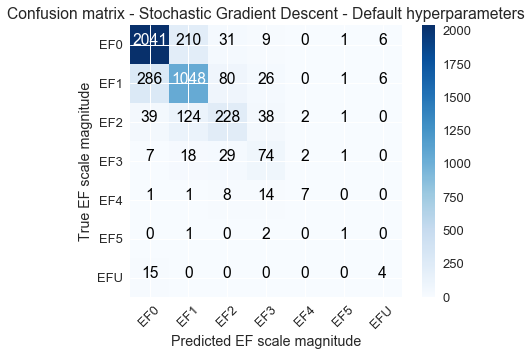

In [317]:
sgd = SGDClassifier(random_state=31)

sgd.fit(Xtrain3_vec6, ytrain3)
yhat3_vec6_sgd = sgd.predict(Xtest3_vec6)

# Computing the confusion matrix
confmatrix_sgd = confusion_matrix(ytest3, yhat3_vec6_sgd)

# Plotting it using the function:
plot_confusion_matrix(confmatrix_sgd, sgd.classes_,
                      'Confusion matrix - Stochastic Gradient Descent - Default hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

- It is better, now the majority of EF3 predictions are correct.
- And true positives of EF4 tornadoes have gone from 1 to 7, this is a huge improvement.

### More ngrams

In [23]:
countvec8 = CountVectorizer(stop_words=countvec_stopwords3, ngram_range=(1,3), max_features=20000)

In [318]:
tokenize_naiveb_scores(countvec8, Xtrain3_nodamage, Xtest3_nodamage, print_scores=True,
                       print_extra_info='ngrams 3')

Multinomial NB	 | 20000 features | ngrams 3			 | Accuracy:	0.777
										 | Recall EF0:	0.84
										 | Recall EF1:	0.771
										 | Recall EF2:	0.65
										 | Recall EF3:	0.45
										 | Recall EF4:	0.032
										 | Recall EF5:	0.25


[0.777, 0.84, 0.771, 0.65, 0.45, 0.032, 0.25]

In [337]:
tokenize_sgd_scores(countvec8, Xtrain3_nodamage, Xtest3_nodamage, print_scores=True,
                    print_extra_info='ngrams 3')

Stochastic GD	 | 20000 features | ngrams 3	 | Accuracy:	0.784
									 | Recall EF0:	0.897
									 | Recall EF1:	0.755
									 | Recall EF2:	0.44
									 | Recall EF3:	0.458
									 | Recall EF4:	0.29
									 | Recall EF5:	0.25


[0.784, 0.897, 0.755, 0.44, 0.458, 0.29, 0.25]

- We improved the accuracy compared to ngrams=(1,2), in both cases Naive Bayes and Stochastic Gradient Descent
- Recall of EF0, EF1 and EF4 got better too. EF2 and EF3 got worse.
- Overall, SGD is better than NB, even though NB models better middle size tornadoes (EF1 and EF2).

In [320]:
# Saving the scores:
tmp_score_list = tokenize_sgd_scores(countvec8, Xtrain3_nodamage, Xtest3_nodamage)
for i, score in enumerate(scores_nlp):
    score['cntv8 - ngrams 1 to 3'] = tmp_score_list[i]
recallEF2_nlp

{'cntv2 - part3 reference': 0.65,
 'cntv3 - nltk stopwords': 0.657,
 'cntv5 - nodamage new word': 0.657,
 'cntv6 - no reference to target': 0.618,
 'cntv6b - SGD model': 0.528,
 'cntv7 - no reference to numbers': 0.444,
 'cntv8 - ngrams 1 to 3': 0.44}

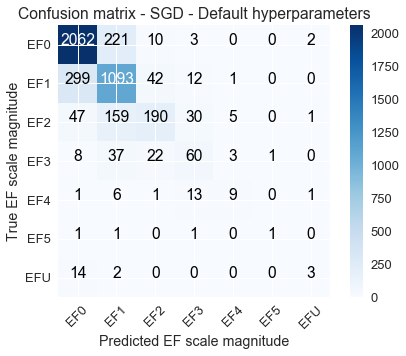

In [321]:
Xtrain3_vec8 = countvec8.fit_transform(Xtrain3_nodamage)
Xtest3_vec8 = countvec8.transform(Xtest3_nodamage)

sgd = SGDClassifier(random_state=31)
sgd.fit(Xtrain3_vec8, ytrain3)
yhat3_vec8_sgd = sgd.predict(Xtest3_vec8)

# Computing the confusion matrix
confmatrix_sgd = confusion_matrix(ytest3, yhat3_vec8_sgd)

# Plotting it using the function:
plot_confusion_matrix(confmatrix_sgd, sgd.classes_,
                      'Confusion matrix - SGD - Default hyperparameters',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

- The true positives of EF4 tornadoes went again up: from 7 to 9.
- Even though the recall of EF5 tornadoes is the same, ie the true positive is still equal to 1, and the sum of false negatives = 3, the distribution of the false negatives is worse: one EF5 tornado is even predicted as EF0! Analysing the recall is not enough, thorough analysis of the confusion matrix is needed.
- Nevertherless, in terms of scoring, this result using SGD with ngrams 1 to 3 is the best so far.

- I also tested higher ngrams, but it was giving worse results.

### Upsampling EF3 to EF5 tornadoes

Upsampling the train dataset can help improving the recall on stronger tornadoes on the test dataset.

In [329]:
# Re-incorporating the magnitude:
Xtrain4 = pd.concat([Xtrain3_nodamage, pd.DataFrame(ytrain3)], axis=1)
print Xtrain3_nodamage.shape, Xtrain4.shape
Xtrain4.head(2)

(10175,) (10175, 2)


,EVENT_NARRATIVE,TOR_F_SCALE
13291,A survey team found damage consisten tiwht an ...,EF0
1056,This tornado first touched down approximately ...,EF2


In [330]:
# Creating a dictionary of dataframes, ones for each magnitude:
Xtrain4_perMag = {}
for mag in ['EF0', 'EFU', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']:
    Xtrain4_perMag[mag] = Xtrain4[Xtrain4['TOR_F_SCALE']==mag]

In [331]:
# Upsampling each dataframe based on the number of rows of the majority class EF0:
Xtrain4_upsampled = {}

for mag in ['EF0', 'EFU', 'EF1', 'EF2', 'EF3', 'EF4', 'EF5']:
    
    if mag in ['EF0', 'EFU', 'EF1', 'EF2']:
        Xtrain4_upsampled[mag] = Xtrain4_perMag[mag]
    else:
        # Bootstrapping method is used:
        Xtrain4_upsampled[mag] = resample(Xtrain4_perMag[mag], replace=True,
                                          n_samples=Xtrain4_perMag['EF2'].shape[0],
                                          random_state=31)
    # QCs:
    print "{} Original shape :\t".format(mag), Xtrain4_perMag[mag].shape,\
          "\tUpsample shape {}:".format(mag), Xtrain4_upsampled[mag].shape
        

EF0 Original shape :	(5362, 2) 	Upsample shape EF0: (5362, 2)
EFU Original shape :	(43, 2) 	Upsample shape EFU: (43, 2)
EF1 Original shape :	(3375, 2) 	Upsample shape EF1: (3375, 2)
EF2 Original shape :	(1009, 2) 	Upsample shape EF2: (1009, 2)
EF3 Original shape :	(304, 2) 	Upsample shape EF3: (1009, 2)
EF4 Original shape :	(72, 2) 	Upsample shape EF4: (1009, 2)
EF5 Original shape :	(10, 2) 	Upsample shape EF5: (1009, 2)


In [332]:
# Concatenating all the upsampled dataframes
Xtrain4_df = pd.concat([Xtrain4_upsampled['EF0'], Xtrain4_upsampled['EF1'],
                        Xtrain4_upsampled['EF2'], Xtrain4_upsampled['EF3'], 
                        Xtrain4_upsampled['EF4'], Xtrain4_upsampled['EF5'],
                        Xtrain4_upsampled['EFU']], ignore_index=True, axis=0)
print Xtrain4_df.shape
Xtrain4_df.head(2)

(12816, 2)


,EVENT_NARRATIVE,TOR_F_SCALE
0,A survey team found damage consisten tiwht an ...,EF0
1,This tornado occurred in open country and impa...,EF0


In [333]:
# Recreating the feature matrix and target for modelling:
ytrain4 = Xtrain4_df.TOR_F_SCALE
Xtrain4_df.drop(['TOR_F_SCALE'], axis=1, inplace=True)
Xtrain4_df = Xtrain4_df.EVENT_NARRATIVE
print Xtrain4_df.shape, ytrain4.shape

(12816,) (12816,)


In [351]:
# Redoing the modeling, with best obtained so far 
# (maxfeatures 20000, ngrams 3, new word no_damage, stopwords including references to scale, sgd)
countvec9 = CountVectorizer(stop_words=countvec_stopwords3, ngram_range=(1,3),
                            max_features=20000)
tokenize_sgd_scores(countvec9, Xtrain4_df, Xtest3_nodamage, ytrain4, ytest3,
                    print_scores=True, print_extra_info='upsampling EF3 to EF5')

Stochastic GD	 | 20000 features | upsampling EF3 to EF5	 | Accuracy:	0.771
									 | Recall EF0:	0.903
									 | Recall EF1:	0.668
									 | Recall EF2:	0.549
									 | Recall EF3:	0.565
									 | Recall EF4:	0.226
									 | Recall EF5:	0.25


[0.771, 0.903, 0.668, 0.549, 0.565, 0.226, 0.25]

- Accuracy is lower
- Recall of EF0, EF2 and EF3 tornadoes has increased. Recall EF1 and EF4 has decreased. 
- It is not a very conclusive test.

In [338]:
# Saving the scores:
tmp_score_list = tokenize_sgd_scores(countvec9, Xtrain4_df, Xtest3_nodamage, ytrain4, ytest3)
for i, score in enumerate(scores_nlp):
    score['cntv9 - sgd - upsampling'] = tmp_score_list[i]
recallEF2_nlp

{'cntv2 - part3 reference': 0.65,
 'cntv3 - nltk stopwords': 0.657,
 'cntv5 - nodamage new word': 0.657,
 'cntv6 - no reference to target': 0.618,
 'cntv6b - SGD model': 0.528,
 'cntv7 - no reference to numbers': 0.444,
 'cntv8 - ngrams 1 to 3': 0.44,
 'cntv9 - sgd - upsampling': 0.549}

### Introducing the length of the narrative as a feature

By inspecting more the data, I could realize the that stronger tornadoes have a bigger narrative. Let's include this as a new variable

In [339]:
Xtrain3_nodamage_df = pd.DataFrame(Xtrain3_nodamage.reset_index(drop=True))
Xtrain3_nodamage_df['txt_length'] = Xtrain3_nodamage_df.EVENT_NARRATIVE.map(lambda txt: len(txt))
Xtrain3_nodamage_df.head(2)

,EVENT_NARRATIVE,txt_length
0,A survey team found damage consisten tiwht an ...,390
1,This tornado first touched down approximately ...,1562


In [345]:
ytrain3.reset_index(drop=True, inplace=True)
ytrain3.head(2)

0    EF0
1    EF2
Name: TOR_F_SCALE, dtype: object

The two lists above illustrate my point: the EF2 tornado has more narrative text than the EF0 one.

In [346]:
# Same kind of DF for test set:
Xtest3_nodamage_df = pd.DataFrame(Xtest3_nodamage.reset_index(drop=True))
Xtest3_nodamage_df['txt_length'] = Xtest3_nodamage_df.EVENT_NARRATIVE.map(lambda txt: len(txt))

ytest3.reset_index(drop=True, inplace=True)

Creating a new feature matrix with the length of the narrative and the best count vectorizer:

In [341]:
Xtrain5 = pd.concat([Xtrain3_nodamage_df[['txt_length']],
                     pd.DataFrame(Xtrain3_vec8.todense(),
                                  columns=countvec8.get_feature_names())], axis=1)
Xtrain5.head(2)

,txt_length,00,00 cst,00 pm,000,000 chickens,000 dollars,000 feet,000 pounds,001,...,years old,yellow,york,york county,young,zandt,zandt county,zero,zion,zion road
0,390,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1562,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [342]:
# Same for test set:
Xtest5 = pd.concat([Xtest3_nodamage_df[['txt_length']],
                    pd.DataFrame(Xtest3_vec8.todense(),
                                 columns=countvec8.get_feature_names())], axis=1)

As we now have another feature and it is numerical, I am going to use RF:

In [357]:
# Best RF so far:
rf9 = RandomForestClassifier(random_state=31, min_samples_leaf=1, n_estimators=80,
                             min_samples_split=8, criterion='entropy', 
                             max_features=0.4, max_depth=24, 
                             verbose=1, n_jobs=2)
rf9.fit(Xtrain5, ytrain3)
yhat5_rf9 = rf9.predict(Xtest5)
accuracy_rf9 = accuracy_score(ytest3, yhat5_rf9)
print "Accuracy | Test\t\t | Random Forest\t | length + cvect\t | Prev test param:\t", round(accuracy_rf9, 3)

[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:  4.9min finished
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    0.2s finished


Accuracy | Test		 | Random Forest	 | length + cvect	 | Prev test param:	0.785


This is very similar to the best accuracy score previously obtained with SGD without the text length as a feature (0.784). Let's analyse the recall:

In [358]:
for i in range(6):
    print "\t\t\t\t\t\t\t\t\t\t | Recall EF{}:\t\t".format(i),\
          round(recall_score(ytest3, yhat5_rf9, labels=['EF{}'.format(i)], average='macro'), 3)

										 | Recall EF0:		0.905
										 | Recall EF1:		0.759
										 | Recall EF2:		0.479
										 | Recall EF3:		0.252
										 | Recall EF4:		0.129
										 | Recall EF5:		0.25


- The recall of the weaker tornadoes has increased, but the one of the stronger ones has decreased.
- This test is not going to be chosen.

In [363]:
# Saving the scores:
accuracy_nlp['cntv8b - rf - text length feat'] = round(accuracy_rf9, 3)
for i, score in enumerate(scores_nlp[1:]):
    score['cntv8b - rf - text length feat'] = \
    round(recall_score(ytest3, yhat5_rf9, labels=['EF{}'.format(i)], average='macro'), 3)

In [362]:
accuracy_nlp

{'cntv2 - part3 reference': 0.795,
 'cntv3 - nltk stopwords': 0.792,
 'cntv5 - nodamage new word': 0.796,
 'cntv6 - no reference to target': 0.771,
 'cntv6b - SGD model': 0.78,
 'cntv7 - no reference to numbers': 0.705,
 'cntv8 - ngrams 1 to 3': 0.784,
 'cntv8b - rf - text length feat': 0.785,
 'cntv9 - sgd - upsampling': 0.771}

## Conclusions on our Natural Language Processing analysis

We gathered all the important test scores in the list of dictionaries scores_nlp. 
<br>We can now use it to plot the scores as a function of the test, and have a better overview.

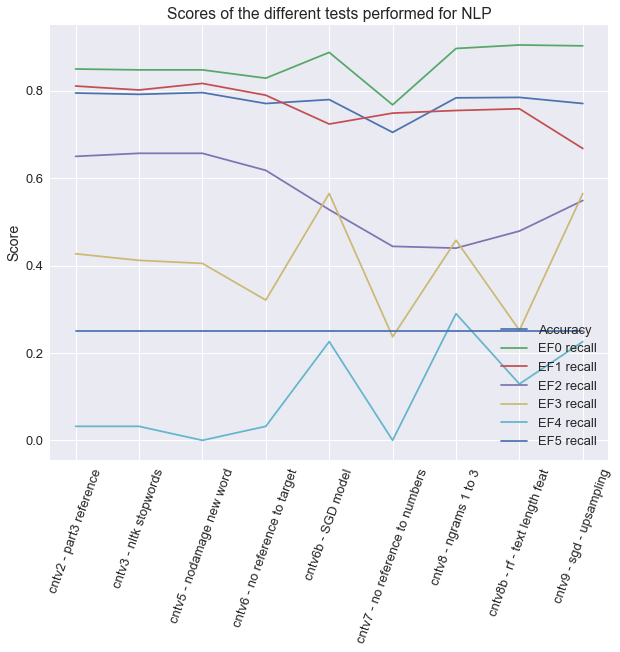

In [413]:
xTicks = sorted(scores_nlp[0].keys())
plt.figure(figsize=(10,8))
plt.title("Scores of the different tests performed for NLP")
plt.xticks(range(9), xTicks, rotation=70)
plt.ylabel("Score")
labels = ['Accuracy','EF0 recall','EF1 recall','EF2 recall','EF3 recall','EF4 recall',
          'EF5 recall']
for i, score in enumerate(scores_nlp):
    y = [value for (key, value) in sorted(score.items())]
    plt.plot(y, label=labels[i])
plt.legend(loc='lower right')
plt.show()

- It is clearly visible on this graph that the introduction of the Stochastic Gradient Descent at test 6b, brought a significant improvement on all scores except EF1 and EF2 recalls.
- Test 7 shows us that numbers are important in the modelling of narrative features. They correspond to references to wind speed for example.
- Test 8: apart from EF2 and EF3 tornadoes, all other predictions are better than test 6b.
- Test 8b shows that the text length is not very representative of EF3 and EF4 tornadoes (their recall decreases)
- Test 9 representing the upsampling is interesting: EF2 and EF3 are getting better, but EF1 tornadoes are getting their lowest recall.
<br><br>
- Test 8 seems like a good compromise

**Summary of the chosen parameters based on the various statistics:**
- Creation of 'nodamage' new word.
- Count Vectorizer default stop words.
- Removal of references to target.
- Keeping the numbers references.
- Stochastic Gradient Descent model.
- No upsampling of stronger tornadoes
- ngrams 1 to 3

# Gathering the numerical features + count vectorized narrative

In [14]:
# We have to join X1 and X3
X1.head(2)
print X1.shape, X3.shape

(14537, 11) (14537,)


In [24]:
X1.reset_index(drop=True, inplace=True)

X3_vec8 = countvec8.fit_transform(X3.map(replace_nodamage))

X3_vec8_df = pd.DataFrame(X3_vec8.todense(), columns=countvec8.get_feature_names())

X4 = pd.concat([X1, X3_vec8_df], axis=1)

In [475]:
print X4.shape
X4.head(2)

(14537, 20011)


,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,...,years old,yellow,york,york county,young,zandt,zandt county,zero,zion,zion road
0,-0.649575,-0.553936,-0.663909,0.71888,0.064657,-0.048934,-0.06017,0.992225,-0.148975,1.408556,...,0,0,0,0,0,0,0,0,0,0
1,-0.665453,-0.553936,-0.663909,0.71888,0.142239,-0.048934,-0.06017,0.978331,-0.115564,1.354156,...,0,0,0,0,0,0,0,0,0,0


In [25]:
Xtrain4, Xtest4, ytrain4, ytest4 = train_test_split(X4, y1, test_size=0.3, stratify=y1,
                                                    random_state=31)

In [233]:
rf9 = RandomForestClassifier(random_state=31, min_samples_leaf=1, n_estimators=80,
                             min_samples_split=8,
                             criterion='entropy', max_features=0.4, max_depth=24)
rf9.fit(Xtrain4, ytrain4)
yhat4_rf9 = rf9.predict(Xtest4)
accuracy_rf9 = accuracy_score(ytest4, yhat4_rf9)
print "Accuracy | Test\t\t | Random Forest\t | num + cvect\t | Prev test param:\t", round(accuracy_rf9, 3)
for i in range(6):
    print "\t\t\t\t\t\t\t\t\t | Recall EF{}:\t\t".format(i),\
          round(recall_score(ytest4, yhat4_rf9, labels=['EF{}'.format(i)], average='macro'), 3)

Accuracy | Test		 | Random Forest	 | num + cvect	 | Prev test param:	0.812
									 | Recall EF0:		0.911
									 | Recall EF1:		0.8
									 | Recall EF2:		0.542
									 | Recall EF3:		0.397
									 | Recall EF4:		0.161
									 | Recall EF5:		0.0


- Accuracy has increased a lot
- Recall of all tornadoes has improved, except EF3, EF4 and EF5.
- Even though the accuracy is much better due to great predictions of the lower magnitudes, I would not select this test as the stronger tornadoes do not get predicted as well. This can be noted in the confusion matric too:

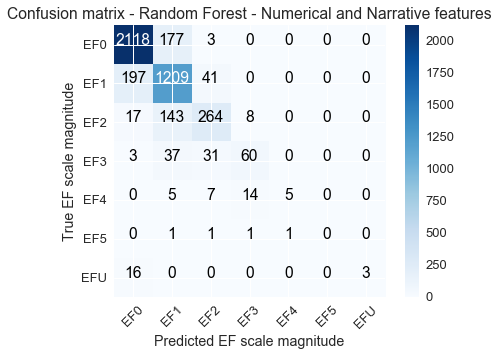

In [193]:
# Computing the confusion matrix
confmatrix_nb = confusion_matrix(ytest4, yhat4_rf9)

# Plotting it using the function:
plot_confusion_matrix(confmatrix_nb, rf9.classes_,
                      'Confusion matrix - Random Forest - Numerical and Narrative features',
                      xlab='Predicted EF scale magnitude', ylab='True EF scale magnitude')
plt.show()

The number of correctly predicted EF4 tornadoes came down to 4, and there is no EF5 tornado correctly predicted.

It could be interesting to redo a gridsearch.

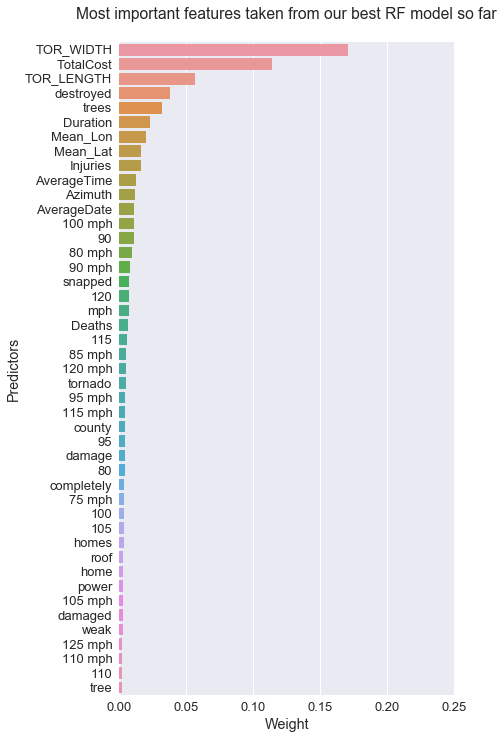

In [234]:
plot_RF_important_features(XtrainDF=Xtrain4, fitted_rf=rf9, weight_threshold_for_display=0.002,
                           figsize=(6,12),
                           title_test="Most important features taken from our best RF model so far\n")

- The most important features are interesting and show we could still bring some improvements and gather words like "damage" and "damaged", or "90" and "90 mph". Even though we saw in part 3 that they do not bring much to the accuracy, I think more testing on lemmatization and tf-idf could lead to a better result.

- Testing other types of models would be good, and also optimizing their hyperparameters.

- Another interesting test would be the sentiment analysis.

# Predicting the total damage cost

Now that we have helped determining the tornado magnitude based on narrative text from various sources, we can try and predict the cost of damage, which could help counties plan for future possible protection budgets. Insurance companies could also be a target for this study.

In [421]:
# Removing wrong outlier and displaying info:
dfnew = df[df['TOR_LENGTH']<50]
dfnew.reset_index(drop=True, inplace=True)
print dfnew.shape
dfnew.info()

(14537, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14537 entries, 0 to 14536
Data columns (total 14 columns):
TOR_F_SCALE    14537 non-null object
TOR_LENGTH     14537 non-null float64
TOR_WIDTH      14537 non-null float64
Duration       14537 non-null int64
AverageDate    14537 non-null int64
AverageTime    14537 non-null float64
Deaths         14537 non-null int64
Injuries       14537 non-null int64
Mean_Lat       14537 non-null float64
Mean_Lon       14537 non-null float64
Azimuth        14537 non-null float64
State          14537 non-null object
TotalCost      14537 non-null int64
Source         14537 non-null object
dtypes: float64(6), int64(5), object(3)
memory usage: 1.6+ MB


In [422]:
dfnew.head(2)

,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,State,TotalCost,Source
0,EF0,0.27,20.0,1,208,15.855,0,0,41.7345,-93.3220,120.34,IA,0,Public
1,EF0,0.20,20.0,1,208,16.255,0,0,41.6694,-93.0534,117.98,IA,0,Law_Enforcement


## Feature matrix and target

In [423]:
# Feature matrix:
Xnew1 = dfnew.drop(['TotalCost'], axis=1)

# As we saw in the previous analyses to predict the scale of a tornado, the unidentifies ones 
# (ie EFU) are in most cases EF0 tornadoes. We are therefore going to replace all the EFU by EF0.
Xnew1.TOR_F_SCALE = Xnew1.TOR_F_SCALE.map(lambda scale: 'EF0' if scale=='EFU' else scale)

# Standardizing numerical features:
numfeat = ['TOR_LENGTH', 'TOR_WIDTH', 'Duration', 'AverageDate', 'AverageTime', 'Deaths',
           'Injuries', 'Mean_Lat', 'Mean_Lon', 'Azimuth']
scaler = StandardScaler()
Xnew1num = pd.DataFrame(scaler.fit_transform(Xnew1[numfeat]), columns=numfeat)

# Dummifying categorical features:
catfeat = ['TOR_F_SCALE', 'State', 'Source']
Xnew1 = pd.concat([Xnew1num, Xnew1[catfeat]], axis=1)
Xnew1 = pd.get_dummies(Xnew1, prefix=['Scale','State','Source'], columns=catfeat)
Xnew1.drop(['Scale_EF0','State_TX','Source_NWS_Storm_Survey'], axis=1, inplace=True)

print dfnew.shape, Xnew1.shape
Xnew1.head(2)

(14537, 14) (14537, 91)


,TOR_LENGTH,TOR_WIDTH,Duration,AverageDate,AverageTime,Deaths,Injuries,Mean_Lat,Mean_Lon,Azimuth,...,Source_Official_NWS_Observations,Source_Other_Federal_Agency,Source_Park/Forest_Service,Source_Public,Source_Social_Media,Source_State_Official,Source_Storm_Chaser,Source_Trained_Spotter,Source_Unknown,Source_Utility_Company
0,-0.659078,-0.553944,-0.663874,0.718893,0.064674,-0.048936,-0.060172,0.992459,-0.148916,1.408516,...,0,0,0,1,0,0,0,0,0,0
1,-0.675226,-0.553944,-0.663874,0.718893,0.142254,-0.048936,-0.060172,0.978564,-0.115505,1.354118,...,0,0,0,0,0,0,0,0,0,0


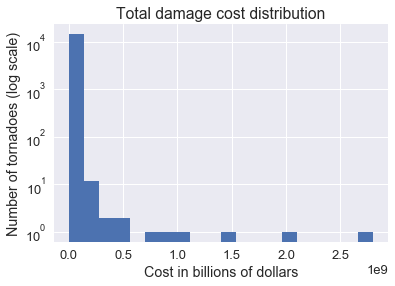

In [425]:
# Target:
ynew1 = dfnew['TotalCost']
plt.figure(figsize=(6,4))
plt.title("Total damage cost distribution")
plt.ylabel("Number of tornadoes (log scale)")
plt.xlabel("Cost in billions of dollars")
ynew1.hist(bins=20, log=True)
plt.show()

The data being strongly postively skewed, the median is a better representation than the mean. This will be our baseline.

In [49]:
ynew1.describe()

count    1.453700e+04
mean     1.487303e+06
std      3.516064e+07
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+03
75%      7.500000e+04
max      2.800000e+09
Name: TotalCost, dtype: float64

## Modelling

### Train/test split

In [464]:
Xnewtrain1, Xnewtest1, ynewtrain1, ynewtest1 = train_test_split(Xnew1, ynew1, test_size=0.3,
                                                                random_state=3)

### Baseline

In [465]:
rmse_baseline = np.sqrt(mean_squared_error(ynewtest1, np.tile(ynewtest1.median(), len(ynewtest1))))
R2_baseline = r2_score(ynewtest1, np.tile(ynewtest1.median(), len(ynewtest1)))
print "Baseline RMSE:\t", rmse_baseline
print "Baseline R2:\t", R2_baseline

Baseline RMSE:	33863232.7319
Baseline R2:	-0.00287911086713


### Linear regression, no regularization

In [455]:
linreg1 = LinearRegression()

In [456]:
linreg1.fit(Xnewtrain1, ynewtrain1)
yhatnew1 = linreg1.predict(Xnewtest1)

In [466]:
rmse_linreg1 = np.sqrt(mean_squared_error(ynewtest1, yhatnew1))
R2_linreg1 = r2_score(ynewtest1, yhatnew1)
print "Linear Reg 1 - crossvalidated R2:\t", np.mean(cross_val_score(linreg1, 
                                                                     Xnewtrain1,
                                                                     ynewtrain1, cv=5))
print "Linear Reg 1 - RMSE:\t\t\t", rmse_linreg1
print "Linear Reg 1 - R2:\t\t\t", R2_linreg1

Linear Reg 1 - crossvalidated R2:	-2.80817103928e+21
Linear Reg 1 - RMSE:			9.40080381137e+16
Linear Reg 1 - R2:			-7.72897198798e+18


- This is a very bad modelling.
- When splitting the train/set differently, the scores get also completely different. It is very unstable.

### Linear regression, Lasso regularization

In [467]:
lassoreg1 = Lasso(random_state=31)
lassoreg1.fit(Xnewtrain1, ynewtrain1)
yhatnew_lassoreg1 = lassoreg1.predict(Xnewtest1)
rmse_lassoreg1 = np.sqrt(mean_squared_error(ynewtest1, yhatnew_lassoreg1))
R2_lassoreg1 = r2_score(ynewtest1, yhatnew_lassoreg1)
print "Lasso Reg 1 - crossvalidated R2:\t", np.mean(cross_val_score(lassoreg1, 
                                                                    Xnewtrain1, 
                                                                    ynewtrain1, cv=5))
print "Lasso Reg 1 - RMSE:\t\t\t", rmse_lassoreg1
print "Lasso Reg 1 - R2:\t\t\t", R2_lassoreg1

Lasso Reg 1 - crossvalidated R2:	0.0440209262208
Lasso Reg 1 - RMSE:			21904184.4034
Lasso Reg 1 - R2:			0.580389904378


Lasso regularization gives OK scores. The crossvalidated one is slightly over 0, which means the model is not fitting the data so well.

#### Gridsearch

In [446]:
np.logspace(-2, 3, 6)

array([  1.00000000e-02,   1.00000000e-01,   1.00000000e+00,
         1.00000000e+01,   1.00000000e+02,   1.00000000e+03])

In [468]:
lasso_params = {'alpha': np.logspace(-2, 3, 6)}
lassoreg2 = GridSearchCV(lassoreg1, param_grid=lasso_params, cv=5, n_jobs=2, verbose=1)
lassoreg2.fit(Xnewtrain1, ynewtrain1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:   32.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=31,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=2,
       param_grid={'alpha': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [469]:
lassoreg2.best_score_

0.048179138755453425

In [470]:
lassoreg2.best_params_

{'alpha': 1000.0}

Getting slightly better, but still a long way to go.

Comments on damage cost prediction:
- It does not seems as straight forward as the magnitude prediction.
- It may be due to the highly asymetrical distribution (high postive skew).
- Further testing is required.

# Conclusions

## Parts

This capstone project consists of 5 notebooks:
- [Part 1](tornadoes_part1_project_introduction.ipynb): First analysis of the data and modelling on a subset of 500 tornadoes.
- [Web Scraping](tornadoes_part2_webscraping_posgres.ipynb): Importing a bigger dataset from the web and saving as a local PostgreSQL
- [Part 3](tornadoes_part3_eda_modelling_nlp_tsa.ipynb): work on the dataset of tornadoes which magnitude was measured with EF scale (2007-2017). Final EDA, more modelling, NLP and time series analysis.
- [Pre-Processing class](tornadoes_part4_pre_processing_class.ipynb): Gathering of all the pre-processing steps of part 3 in a single class.
- [Part 5](tornadoes_part5_modelling_upsampling_nlp.ipynb): Upsampling, further NLP testing and a first glance at predicting damage costs.


## EDA

- Extensive EDA and feature engineering was performed.
- Part 1 and part 3 gather most of the insightful discoveries made.

### Time Series Analysis

- The count of tornadoes over time was studied.
- A clear yearly seasonality of the tornadoes was confirmed. Tornadoes are indeed more frequent in the month of April to July.
- Selecting only the count of tornadoes for those months from 1952 until 2017 shows an increase trend. This can be either due to the effects of global warming or (most likely) to better measurments and tornado investigations.

## Predicting the tornadoes' magnitude

### From numerical charactertics

- Logistic Regression, Recurrent Neural Network and Random Forest models were tried.
- We succeeded in a good model, improving the baseline accuracy from 0.527 to 0.732.
- Because of strong imbalance between weak and strong tornadoes, the recall score of these latest is actually a better proof of model quality. 
- Better recall of strong tornadoes was achieved through successfull upsampling (accuracy 0.723).

### From narrative - NLP

- Naive Bayes, Random Forest and Stochastic Gradient Descent were tried.
- Various tests were perfomed on Count Vectorizer. The best obtained model has an accuracy of 0.784.
- There is room for improvement, NLP is a broad topic.

### From both the numerical and text features
- Random Forest was tried. Accuracy score of 0.812 was obtained, but at the expense of the recall of strong tornadoes.

## Possible next steps
- Try more models.
- Include the tornadoes which magnitude was measures with the F scale (tornadoes between 1952 and 2006) and retest modelling.
- Further test neural network.
- NLP further tests of TF-IDF and lemmatization.
- NLP sentiment analysis.
- Time series analysis: analysing the increase in number of tornadoes trend and forecast the next few years with ARIMA model, including yearly seasonality.
- Predict the total damage cost via regression. First pass of tests were performed. Further analysis and model testing needed.
- Use other datasets already imported in my local postgreSQL database: fatalities and locations datasets.
- Incorporate other datasets to improve predictions: weather data or census data (like average income to predict damages).
- Further work on probabilites: get the probability per county to have a tornado of a certain magnitude in the next 5 years.
- Build an app with Flask and make it publically available: entering the state/county, gives back the probabilities computed previously.